Cruce de predicción del municipio vs chinchetas

In [1]:
#Librerías
import pandas as pd
import geopandas as gpd
import sys
sys.path.append(r"C:\Users\mfpen\Documents\Repositorios\geoloc2\preparacion_datos")
from funciones_cruces_limpieza import *
sys.path.append(r"C:\Users\mfpen\Documents\Repositorios\geoloc2\Valor_Catastral")
from Herramientas import cruzar_chinchetas_vs_dnue
# from google.colab import drive
# drive.mount('/content/drive')

c:\Users\mfpen\anaconda3\envs\YOLO\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\mfpen\AppData\Local\Temp\ipykernel_17232\86875900.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedoc

In [5]:
def choose_city(gdf_zonas):
    '''
        Función para localizar el municipio a tratar dentro del shape de zonas rurales y urbanas
    '''
    zona = input('Digita el código de la zona que quieres (Ej. Ixtapan = 040):')
    gdf_mun = gdf_zonas[gdf_zonas.CVE_MUN == zona]
    #gdf_mun.plot()
    return gdf_mun
    
def cruce_limpieza_shapes(gdf_zonas,gdf_construcciones):
    gdf_mun = choose_city(gdf_zonas)
    gdf_mun = gdf_mun.to_crs(3857)
    gdf_cruce= gdf_construcciones.sjoin(gdf_mun,how='left')
    
    return gdf_cruce

Cruce de chinchetas vs denue

In [41]:
# Usar el de casas original
path_casas = r"D:\Secretaria\cruces_bases\limpiezas_shp_base\Ixtapan\ultimas_versiones\Ixtapan_casas_Indxcurt.shp"
#Usar chinchetas vs denue u la original
path_chinchetas = r"H:\.shortcut-targets-by-id\19j98C-PJkrk3gkgU7V03dLiJ4Gn-hnNe\geoshaps\naucalpan (1)\Chinchetas_naucalpan_limpio_DNUE.shp"
# Usar DENUE_EDOMEX_2022 en Estatal de Geoshaps
path_denue = r"H:\.shortcut-targets-by-id\19j98C-PJkrk3gkgU7V03dLiJ4Gn-hnNe\geoshaps\Estatal\DENUE_EDOMEX_2022.shp"

In [42]:
casas = gpd.read_file(path_casas)
pines = gpd.read_file(path_chinchetas)
# denue = gpd.read_file(path_denue)

In [43]:
casas.columns, pines.columns

(Index(['puntos', 'zona', 'area_left', 'rectangulo', 'Medida_lx', 'Medida_ly',
        'Max_xy', 'Min_xy', 'f_lado', 'f_area', 'ID_ind', 'cve_ent', 'cve_mun',
        'cve_loc', 'id_cat', 'proceso', 'curt', 'notas', 'ID_curt',
        'clase_dete', 'conf', 'area_right', 'status', 'ID_casas', 'CURT_f',
        'CURT_si', 'dupGEO', 'dupCURT', 'YOLO_si', 'Ind_si', 'area',
        'Induxcasa', 'geometry'],
       dtype='object'),
 Index(['Clase', 'tipoCenCom', 'tipo_asent', 'nombre_act', 'clee', 'id',
        'Clase1', 'Clase_lim', 'geometry'],
       dtype='object'))

In [44]:
#Eliminar las columnas que traen el concatenado de CLase y solo dejar la columna buena
pines.drop(['Clase1','Clase'],axis=1,inplace=True)
pines.tail(2)

,tipoCenCom,tipo_asent,nombre_act,clee,id,Clase_lim,geometry
1814,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11088585.525 2131199.662, -11088586..."
1815,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11088485.810 2139040.121, -11088476..."


In [45]:
#La columna de clasificacion de chinchetas debe llamarse Clase, sino cambiar
pines.rename(columns={'Clase_lim':'Clase'},inplace=True)
pines.tail(2)

,tipoCenCom,tipo_asent,nombre_act,clee,id,Clase,geometry
1814,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11088585.525 2131199.662, -11088586..."
1815,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11088485.810 2139040.121, -11088476..."


In [46]:
#En el caso de ya tener pines vs denue, cambiar el nombre de la columna id a ID_denue
pines.rename(columns={'id':'ID_denue'},inplace=True)
pines.tail(2)

,tipoCenCom,tipo_asent,nombre_act,clee,ID_denue,Clase,geometry
1814,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11088585.525 2131199.662, -11088586..."
1815,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11088485.810 2139040.121, -11088476..."


In [ ]:
#En caso de hacer el cruce de pines vs denue, ejecutar esta celda antes del cruce

schema_crs={'set_ch':3857,'to_ch':3857,'set_dnue':6364,'to_dnue':3857}
pines = pines.set_crs(schema_crs['set_ch'],allow_override=True)
denue   = denue.set_crs(schema_crs['set_dnue'],allow_override=True)
pines.set_geometry('geometry',inplace=True)

In [ ]:
cruce_pinesxdenue=cruzar_chinchetas_vs_dnue(pines,denue)

In [ ]:
cruce_pinesxdenue.rename(columns={'id':'ID_denue'},inplace=True)

In [2]:
import numpy as np 
x='hh|jj|hh|jj|ll|i|o'
('|'.join(np.unique(np.array(x.split('|')))))

hh|i|jj|ll|o


In [ ]:
#Guardar el archivo de la siguiente forma: Municipio_casas_pinesxdenue
cruce_pinesxdenue.to_file(r"/Atlacomulco_casas_pinesxdenue.shp")

Cruce de casas x anterior 

In [47]:
casas.shape, pines.shape

((42129, 33), (1816, 7))

In [48]:
cruce_casasxpines=gpd.sjoin(casas,pines, how='left')
cruce_casasxpines

,puntos,zona,area_left,rectangulo,Medida_lx,Medida_ly,Max_xy,Min_xy,f_lado,f_area,...,area,Induxcasa,geometry,index_right,tipoCenCom,tipo_asent,nombre_act,clee,ID_denue,Clase
0,149.0,02,362.867994,504.943293,27.6806,18.2425,27.6806,18.2425,1.517369,0.718631,...,NaN,NaN,"POLYGON ((-11099611.982 2138494.161, -11099589...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,149.0,02,362.867994,504.943293,27.6806,18.2425,27.6806,18.2425,1.517369,0.718631,...,NaN,NaN,"POLYGON ((-11099611.982 2138494.161, -11099589...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,149.0,02,362.867994,504.943293,27.6806,18.2425,27.6806,18.2425,1.517369,0.718631,...,NaN,NaN,"POLYGON ((-11099611.982 2138494.161, -11099589...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,89.0,02,1080.604247,1137.882352,44.4497,25.7522,44.4497,25.7522,1.726054,0.949663,...,NaN,NaN,"POLYGON ((-11101291.160 2138966.151, -11101261...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,89.0,02,1080.604247,1137.882352,44.4497,25.7522,44.4497,25.7522,1.726054,0.949663,...,NaN,NaN,"POLYGON ((-11101291.160 2138966.151, -11101261...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,120.675972,0.0,"POLYGON ((-11088683.142 2135199.640, -11088676...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
42125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,290.627965,0.0,"POLYGON ((-11088600.094 2136546.559, -11088581...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
42126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,231.295612,0.0,"POLYGON ((-11088640.599 2136511.008, -11088633...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
42127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,464.602490,0.0,"POLYGON ((-11088590.924 2136573.546, -11088580...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
#Filtrar las detecciones de casas que cruzan con chinchetas, buscar la columna correspondiente a la deteccion de casas de alexnet de la base de deteccion
cruce_casasxpines.loc[cruce_casasxpines.Clase.notna(),"clase_dete"] = 'establecimiento'

In [50]:
#Filtrar las detecciones de casas que cruzan con chinchetas, buacar la columna correspondiente a la deteccion de casas de alexnet de la base de deteccion
cruce_casasxpines.loc[(cruce_casasxpines['clase_dete'] == 'establecimiento') & (cruce_casasxpines.Clase.isna()),"clase_dete"] = 'casas'

In [12]:
cruce_casasxpines[(cruce_casasxpines.clase_dete== 'establecimiento') & (cruce_casasxpines.Clase.isna())]

,cve_ent,cve_mun,cve_loc,id_cat,proceso,curt,notas,ID_curt,clase_dete,conf,...,dupCURT,YOLO_si,geometry,index_right,tipoCenCom,tipo_asent,nombre_act,clee,ID_denue,Clase


In [51]:
print('Columas de casas: ', casas.columns)
if input('Quiere crear la columna ID_casas') in ['1','si']:
    casas.reset_index(drop=False, inplace=True)
    casas.rename(columns={'index':'ID_casas'},inplace=True)

Columas de casas:  Index(['puntos', 'zona', 'area_left', 'rectangulo', 'Medida_lx', 'Medida_ly',
       'Max_xy', 'Min_xy', 'f_lado', 'f_area', 'ID_ind', 'cve_ent', 'cve_mun',
       'cve_loc', 'id_cat', 'proceso', 'curt', 'notas', 'ID_curt',
       'clase_dete', 'conf', 'area_right', 'status', 'ID_casas', 'CURT_f',
       'CURT_si', 'dupGEO', 'dupCURT', 'YOLO_si', 'Ind_si', 'area',
       'Induxcasa', 'geometry'],
      dtype='object')


In [52]:
cruce_casasxpines.rename(columns={"index_right":"ID_chin"},inplace=True)

La siguiente celda es para saber cuántos valores únicos hay en cada base

In [53]:
len(casas.geometry.unique())#,len(pines.geometry.unique())

22845

Cruce para identificación de zonas rurales y urbanas

In [19]:
#Lectura de base de zonas
zonas = gpd.read_file(r"D:\Secretaria\Bases_shp_INEGI\zonas_rurales_urbanas\15m.shp")
zonas.tail(2)

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry
160098,1512500010016004,15,125,0001,0016,004,Urbana,Típica,"POLYGON ((2807844.209 857424.049, 2807852.408 ..."
160099,1512500010016025,15,125,0001,0016,025,Urbana,Típica,"POLYGON ((2807780.538 857336.969, 2807799.790 ..."


<Axes: >

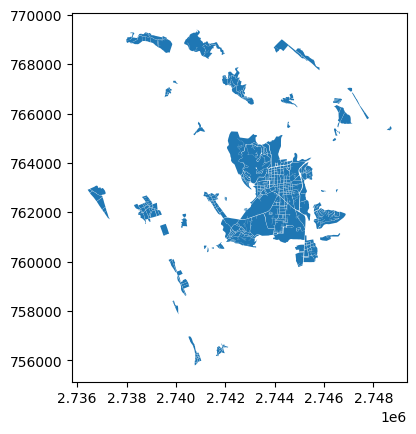

In [54]:
zona_Ixta=zonas[zonas.CVE_MUN=='040']
zona_Ixta.plot()

Cruce de zonas vs construcciones

In [55]:
#Base del cruce con areas rurales y urbanas   casas vs 15m
#base_ur = gpd.read_file(r"D:\Secretaría\cruces_bases\Zona_rurales_urbanas\crucexzonas_rurales_urbanas.shp")
base_ur = gpd.sjoin(cruce_casasxpines,zona_Ixta.to_crs(3857),how='left')
base_ur.rename(columns={'index_right':'ID_15m'},inplace=True)
base_ur.shape, cruce_casasxpines.shape

((46020, 49), (43623, 40))

In [56]:
len(base_ur.geometry.unique())

22845

In [57]:
base_ur[base_ur.geometry.isin(base_ur.geometry.value_counts()[base_ur.geometry.value_counts()>1].index)].tail(2)

,puntos,zona,area_left,rectangulo,Medida_lx,Medida_ly,Max_xy,Min_xy,f_lado,f_area,...,Clase,ID_15m,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA
41193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,57874.0,150400018006A005,15,040,0018,006A,005,Rural,Típica
41193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,57875.0,150400018006A004,15,040,0018,006A,004,Rural,Típica


In [58]:
# Ejes de calles
ejes_path = r"H:\.shortcut-targets-by-id\1xy7wVmj8pxJHqeyV9CG1vOBQs3emChdq\Geo\Data\DELEGACIONES_EDOMEX\IXTAPAN DE LA SAL\Ejes_Ixtapan_Sal.shp"
ejes = gpd.read_file(ejes_path)
ejes = ejes.to_crs(3857)
ejes.tail(2)

,STREETS,BANDA,geometry
2541,SIN NOMBRE,NaN,"LINESTRING (-11094855.669 2134653.725, -110948..."
2542,NaN,NaN,"LINESTRING (-11095010.198 2134729.794, -110949..."


In [59]:
cruce_ejes = base_ur.sjoin(ejes)
print(cruce_ejes.shape)
'Porcentaje a borrar: ',cruce_ejes.shape[0]/base_ur.shape[0]*100

(12654, 52)


('Porcentaje a borrar: ', 27.496740547588004)

In [60]:
import numpy as np 
print('Shape original: ', base_ur.shape)
index_drop = np.unique(base_ur[base_ur.geometry.isin(cruce_ejes.geometry)].index.values)
base_ur.drop(index=index_drop,inplace=True)
print('Shape final:    ', base_ur.shape)

Shape original:  (46020, 49)
Shape final:     (36448, 49)


In [64]:
base_ur.columns

Index(['puntos', 'zona', 'area_left', 'rectangulo', 'Medida_lx', 'Medida_ly',
       'Max_xy', 'Min_xy', 'f_lado', 'f_area', 'ID_ind', 'cve_ent', 'cve_mun',
       'cve_loc', 'id_cat', 'proceso', 'curt', 'notas', 'ID_curt',
       'clase_dete', 'conf', 'area_right', 'status', 'ID_casas', 'CURT_f',
       'CURT_si', 'dupGEO', 'dupCURT', 'YOLO_si', 'Ind_si', 'area',
       'Induxcasa', 'geometry', 'ID_chin', 'tipoCenCom', 'tipo_asent',
       'nombre_act', 'clee', 'ID_denue', 'Clase', 'ID_15m', 'CVEGEO',
       'CVE_ENT', 'CVE_MUN', 'CVE_LOC', 'CVE_AGEB', 'CVE_MZA', 'AMBITO',
       'TIPOMZA'],
      dtype='object')

In [65]:
try:
    base_ur = base_ur[['ID_casas','clase_dete','Clase','id_cat','curt','CURT_f','geometry','puntos', 'zona', 'area_left',
                        'rectangulo', 'Medida_lx', 'Medida_ly','Max_xy', 'Min_xy', 'f_lado', 'f_area', 'ID_ind', 
                        'cve_ent', 'cve_mun','cve_loc',  'proceso',  'notas', 'ID_curt','conf', 'area_right', 
                        'status',  'CURT_si','dupGEO', 'dupCURT', 'YOLO_si', 'Ind_si', 'area', 'Induxcasa',
                        'ID_chin', 'tipoCenCom', 'tipo_asent', 'nombre_act', 'clee','ID_denue',  'ID_15m', 
                        'CVEGEO', 'CVE_ENT','CVE_MUN','CVE_LOC', 'CVE_AGEB', 'CVE_MZA', 'AMBITO', 'TIPOMZA']]
except:
    base_ur = base_ur[['ID_casas','clase_dete','Clase','id_cat','curt','CURT_f','geometry','puntos', 'zona', 'area_left',
                        'rectangulo', 'Medida_lx', 'Medida_ly','Max_xy', 'Min_xy', 'f_lado', 'f_area', 'ID_ind', 
                        'cve_ent', 'cve_mun','cve_loc',  'proceso',  'notas', 'ID_curt','conf', 'area_right', 
                        'status',  'CURT_si','dupGEO', 'dupCURT', 'YOLO_si', 'Ind_si', 'area', 'Induxcasa',
                        'ID_chin', 'tipoCenCom', 'tipo_asent', 'nombre_act', 'clee','ID_denue',  'ID_15m', 
                        'CVEGEO', 'CVE_ENT','CVE_MUN','CVE_LOC', 'CVE_AGEB', 'CVE_MZA', 'AMBITO', 'TIPOMZA']]

In [66]:
base_ur.tail(3)

,ID_casas,clase_dete,Clase,id_cat,curt,CURT_f,geometry,puntos,zona,area_left,...,ID_denue,ID_15m,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA
42126,29205.0,casas,NaN,NaN,NaN,18503596579936391706,"POLYGON ((-11088640.599 2136511.008, -11088633...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42127,29206.0,casas,NaN,NaN,NaN,18503777899936373374,"POLYGON ((-11088590.924 2136573.546, -11088580...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42128,29207.0,casas,NaN,NaN,NaN,18503736079936371225,"POLYGON ((-11088580.218 2136547.235, -11088561...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
base_ur.to_file(r'D:\Secretaria\cruces_bases\limpiezas_shp_base\Ixtapan\ultimas_versiones\Ixtapan_casas_cruces_todos.shp',
                 index=False)